# Predicting Win Rate for Dota 2 Teams

A case study in determining the outcome for a Dota 2 match based only on team compositions.
Dataset was taken from [here](https://archive.ics.uci.edu/dataset/367/dota2+games+results). 

In [28]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import json 

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1) Data exploration


In [29]:
data_train = pd.read_table('data/dota2Train.csv', delimiter=",", header=None)
data_test = pd.read_table('data/dota2Test.csv', delimiter=",", header=None)

In [30]:
def explore_df(df):
    print(f"Number of samples: {len(df)}")
    print(f"Number of null lines:\n{df.isnull().sum()}")
    print(f"Attributes: {list(df.columns)}")
    print(df.info())
    # print(df.describe())
    return 

explore_df(data_train)
data_train.head(10)


Number of samples: 92650
Number of null lines:
0      0
1      0
2      0
3      0
4      0
      ..
112    0
113    0
114    0
115    0
116    0
Length: 117, dtype: int64
Attributes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92650 entries, 0 to 92649
Columns: 117 entries, 0 to 116
dtypes: int64(117)
memory usage: 82.7 MB
None


,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
5,1,122,2,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
6,1,224,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,227,8,3,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-1,111,2,3,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,-1,151,2,2,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


Exploring the columns, there are no headers. Identify the columns based on the scraping script referenced in the data source link and the [Dota 2 API](https://github.com/kronusme/dota2-api/tree/master/data), we can update the table. JSON files in this repo are taken from the API. 

In [31]:
def json_to_df(filepath, name):
    with open(filepath) as json_file:
        data = json.load(json_file)
    df = pd.DataFrame(data[name])
    # df.set_index('id', inplace=True)
    return df

clusterid = json_to_df('./data/regions.json', 'regions')
gametype = json_to_df('./data/lobbies.json', 'lobbies')
gamemode = json_to_df('./data/mods.json', 'mods')
heroes = json_to_df('./data/heroes.json', 'heroes')
heroes.sort_index(inplace=True)

heroes_num = list(range(1,data_train.shape[1]-3))
heroes_name = ['hero'+str(item) for item in heroes_num]
df_header = ['teamwin', 'clusterid', 'gamemode', 'gametype', *heroes_name]
data_train.columns = df_header
data_test.columns = df_header

heroes.head(10)
# print(heroes_num)

,name,id,localized_name
0,antimage,1,Anti-Mage
1,axe,2,Axe
2,bane,3,Bane
3,bloodseeker,4,Bloodseeker
4,crystal_maiden,5,Crystal Maiden
5,drow_ranger,6,Drow Ranger
6,earthshaker,7,Earthshaker
7,juggernaut,8,Juggernaut
8,mirana,9,Mirana
9,nevermore,11,Shadow Fiend


In [32]:
print('Unique ids')
print(f"Winning team: {data_train['teamwin'].unique()}")
print(f"Locations ids: {data_train['clusterid'].unique()}")
print(f"Game modes: {data_train['gamemode'].unique()}")
print(f"Game types: {data_train['gametype'].unique()}")
print('\nFrequency Analysis')
for idx in ['teamwin', 'gamemode', 'gametype']:
    print(data_train[idx].value_counts())

Unique ids
Winning team: [-1  1]
Locations ids: [223 152 131 154 171 122 224 227 111 151 145 231 188 156 144 153 225 155
 186 181 183 121 187 232 185 192 136 123 132 182 161 191 138 137 134 184
 112 133 212 204 124 261 213 135 211 241 251]
Game modes: [2 8 6 9 1 3 4 7 5]
Game types: [2 3 1]

Frequency Analysis
teamwin
 1    48782
-1    43868
Name: count, dtype: int64
gamemode
2    71897
9    10033
8     8306
1     1229
6      498
3      386
4      208
7       81
5       12
Name: count, dtype: int64
gametype
2    56988
3    35647
1       15
Name: count, dtype: int64


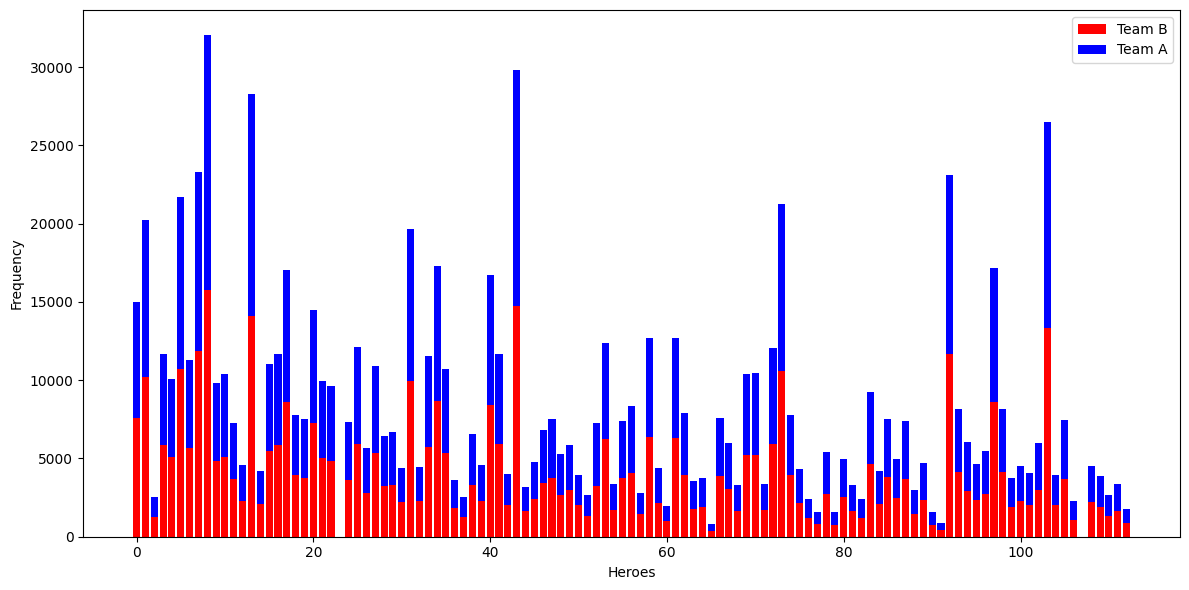

In [33]:
def plot_frequency(df):
    # Count occurrences of -1 and 1 for each column
    X_heros = df.loc[:, "hero1":] # heros only
    hero_id = np.arange(X_heros.shape[1])
    counts_negative = X_heros.apply(lambda col: (col == -1).sum(), axis=0)
    counts_positive = X_heros.apply(lambda col: (col == 1).sum(), axis=0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(hero_id, counts_negative, label='Team B', color='red')  # Bottom segment
    ax.bar(hero_id, counts_positive, bottom=counts_negative, label='Team A', color='blue')  # Top segment
    ax.set_xlabel('Heroes')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_frequency(data_train)

### 2) Preprocessing

* Determine any outliers
* Visualize hero frequencies
* Determine hero wins 
* Visualize regional biases 


Note that hero 24 is missing. There are actually only 112 heroes in the dataset instead of 113 like the max index would suggest. Shouldn't make a difference to any trained model, but let's update the column headers to real names anyway. 

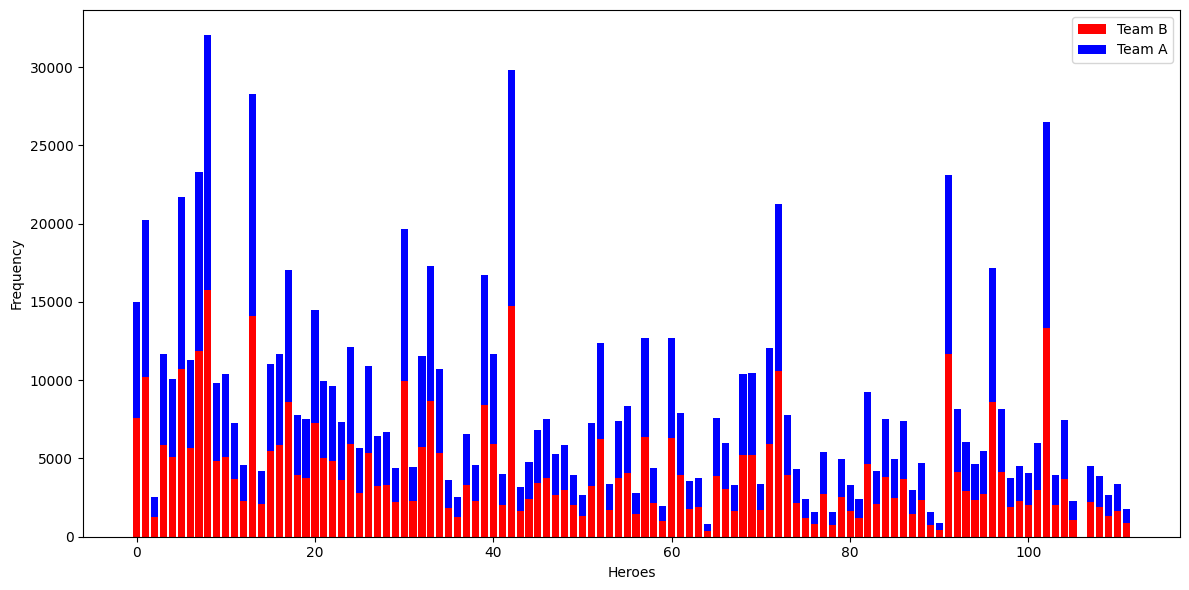

In [34]:
data_train.drop(columns=['hero24'], inplace=True)
data_test.drop(columns=['hero24'], inplace=True)
plot_frequency(data_train)

heroes.sort_index(inplace=True)
heroes_name = list(heroes.name)
df_header = ['teamwin', 'clusterid', 'gamemode', 'gametype', *heroes_name]
data_train.columns = df_header
data_test.columns = df_header

In [35]:
print(data_train.shape)
data_train.head(10)

(92650, 116)


,teamwin,clusterid,gamemode,gametype,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,...,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
5,1,122,2,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
6,1,224,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,227,8,3,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-1,111,2,3,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,-1,151,2,2,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
# most popular heroes 
data_heroes = data_train.iloc[:, 4:]
hero_counts = (data_heroes != 0).sum()
hero_counts = hero_counts.sort_values(ascending=False)
hero_counts.head(5)/data_train.shape[0]

mirana              0.345904
phantom_assassin    0.321662
pudge               0.305289
legion_commander    0.286249
juggernaut          0.251775
dtype: float64

,hero,win_rate
55,omniknight,60.853365
101,elder_titan,58.566874
34,necrolyte,56.445149
65,spectre,55.387449
40,skeleton_king,55.347639


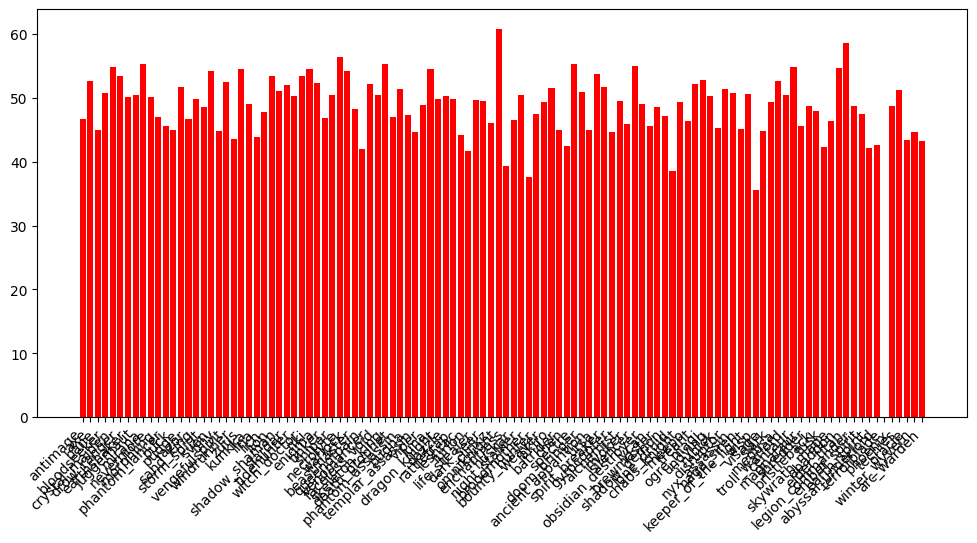

In [ ]:
# most winning heroes out of the number of games they played in
data_wins = data_train.iloc[:, 0]
data_heroes = data_train.iloc[:, 4:]

games_won = {}
games_lost = {}
win_rate = {}
num_of_games = data_wins.shape[0]
for idx, hero_name in enumerate(data_heroes.columns):
    games_won[hero_name] = (data_wins == data_heroes[hero_name]).sum()
    games_lost[hero_name] = ((data_wins != data_heroes[hero_name]) & (data_heroes[hero_name] != 0)).sum()
    win_rate[hero_name] = 100 * (games_won[hero_name] / (games_won[hero_name] + games_lost[hero_name]))
win_rate_df = pd.DataFrame(list(win_rate.items()), columns=['hero', 'win_rate'])

# plot win rate 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(data_heroes.columns, win_rate_df['win_rate'], color='red')  # Bottom segment
fig.autofmt_xdate(rotation=45)

# show highest winning heroes
win_rate_df = win_rate_df.sort_values(by='win_rate', ascending=False)
win_rate_df.head(5)

In [38]:
# types of games played 
counts = data_train['gametype'].value_counts().sort_values()
counts_val = list(counts / num_of_games)
print(counts)

gametype
1       15
3    35647
2    56988
Name: count, dtype: int64


In [39]:
# geographic location
data_train_region = data_train.copy()
mapping_dict = clusterid.set_index('id')['name'].to_dict()
data_train_region['clusterid'] = data_train_region['clusterid'].map(mapping_dict)
data_train_region.head(10)

,teamwin,clusterid,gamemode,gametype,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,...,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,-1,China,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Southeast Asia,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,Europe West,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,Southeast Asia,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,Australia,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
5,1,US East,2,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1
6,1,China,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-1,China,8,3,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,-1,US West,2,3,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,-1,Southeast Asia,2,2,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
data_train_region['clusterid'].value_counts()

clusterid
Southeast Asia    40843
China             23891
Russia             8982
Europe West        5442
US East            2703
South Korea        2444
Europe East        1751
US West            1642
South America      1463
Australia          1122
India               262
Peru                154
Chile               127
South Africa        118
Name: count, dtype: int64

### 3) Building a model

#### Model 1: Logistic regression

In [41]:
print(data_train.isna().any())

# prepare target data
# for simplicity, mark team A win with 1 and team B win with 0
y_train = data_train['teamwin']
y_test = data_test['teamwin']
y_train = y_train.replace(-1, 0) 
y_test = y_test.replace(-1, 0)

# prepare input data
X_train = data_train.drop(['teamwin'], axis=1, inplace=False)
X_test = data_test.drop(['teamwin'], axis=1, inplace=False)

X_train.head()

teamwin          False
clusterid        False
gamemode         False
gametype         False
antimage         False
                 ...  
phoenix          False
techies          False
oracle           False
winter_wyvern    False
arc_warden       False
Length: 116, dtype: bool


,clusterid,gamemode,gametype,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,...,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,223,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,152,2,2,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
2,131,2,2,0,0,0,1,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,154,2,2,0,0,0,0,0,0,-1,...,-1,0,0,0,0,0,0,0,0,0
4,171,2,3,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", model.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return 


In [65]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
print(model)
model.fit(X_train, y_train)

evaluate_metrics(model, X_train, y_train, X_test, y_test)

LogisticRegression()
Training Accuracy: 0.6008742579600648
Testing Accuracy: 0.5971439673596269
Confusion Matrix:
 [[2472 2320]
 [1827 3675]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.52      0.54      4792
           1       0.61      0.67      0.64      5502

    accuracy                           0.60     10294
   macro avg       0.59      0.59      0.59     10294
weighted avg       0.60      0.60      0.59     10294



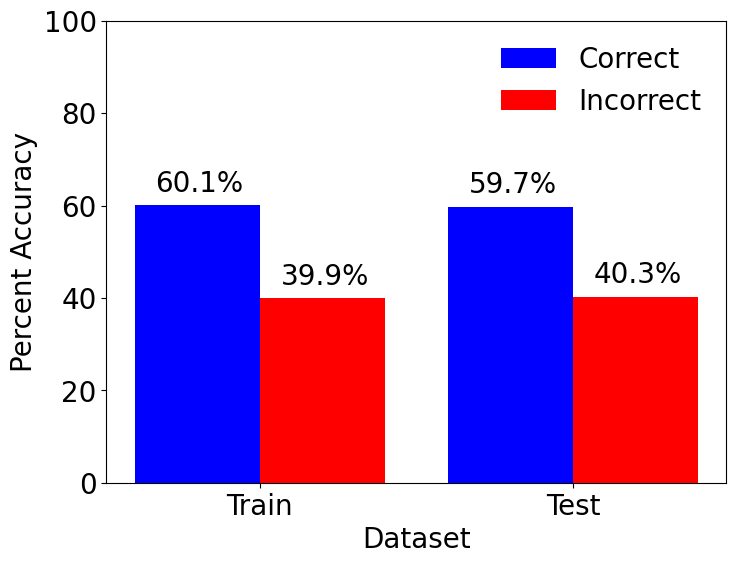

In [66]:
def get_accuracy(model, X_train, y_train, X_test, y_test):
    train_correct = model.score(X_train, y_train)*100
    train_incorrect = 100-train_correct 
    test_correct = model.score(X_test, y_test)*100
    test_incorrect = 100-test_correct 
    correct = [train_correct, test_correct]
    incorrect = [train_incorrect,test_incorrect]
    return correct, incorrect

def plot_accuracy(correct, incorrect):
    # bar graph
    barWidth = 0.40
    fsz_ax = 20
    fig, ax = plt.subplots(figsize=(8, 6))
    br1 = list(np.arange(len(correct))) 
    br2 = [x + barWidth for x in br1] 
    plt.bar(br1, correct, color ='b', width = barWidth, label ='Correct') 
    plt.bar(br2, incorrect, color ='r', width = barWidth, label ='Incorrect') 

    # format
    ax.set_xlabel('Dataset', fontsize=fsz_ax)
    ax.set_ylabel('Percent Accuracy', fontsize=fsz_ax)
    plt.xticks([r + barWidth/2 for r in range(len(correct))], ['Train', 'Test'])
    plt.xticks(fontsize=fsz_ax)
    plt.yticks(fontsize=fsz_ax)
    plt.ylim([0, 100])
    plt.legend(fontsize=fsz_ax, frameon=False)
    # text labels
    offset = 3
    allYValues = correct+incorrect
    allXValues = br1+br2
    for idx, value in enumerate(allYValues):
        plt.text(allXValues[idx]-barWidth/3, value+offset, str(round(value, 1))+'%', fontsize=20)
    return fig

correct, incorrect = get_accuracy(model, X_train, y_train, X_test, y_test)
fig = plot_accuracy(correct, incorrect)
fig.savefig("m1_accuracy.png", bbox_inches="tight", transparent=True)

#### Model 2: XGBoost

A logistic regression model could be too simplistic. Despite the low visual correlation between team composition and team win, let's try a decision tree algorithm to high-throughput possible model hyperparameters and maybe find an optimum one. 
XGBoost is a decision tree algorithm for creating an ensemble of decision trees that self correct from prior results. The native RandomForest and DecisionTree classifiers in sklearn are too slow for this size of a dataset due to the number of features (mainly the number of heroes). 

First need to do a hyperparameter search. Here I first do a broad RandomizedSearchCV, then narrow down with a more exhaustive GridSearchCV model selection. For performance reasons I'll leave the search cells commented out. 

In [45]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint 

Randomized search

In [46]:

'''
model = XGBClassifier()

### parameters used for initial randomized search 
params = {
    "eval_metric": ["logloss"],
    "objective": ['binary:logistic'],
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.5),
    'min_child_weight': randint(1, 6),
    'n_estimators': randint(50, 300), 
    'colsample_bytree': uniform(0.4, 0.6), 
    'reg_alpha': uniform(0, 0.1),  
    'reg_lambda': uniform(1, 99), 
}
grid_search = RandomizedSearchCV(model, param_distributions=params, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
'''

'\nmodel = XGBClassifier()\n\n### parameters used for initial randomized search \nparams = {\n    "eval_metric": ["logloss"],\n    "objective": [\'binary:logistic\'],\n    \'max_depth\': randint(3, 6),\n    \'learning_rate\': uniform(0.01, 0.5),\n    \'min_child_weight\': randint(1, 6),\n    \'n_estimators\': randint(50, 300), \n    \'colsample_bytree\': uniform(0.4, 0.6), \n    \'reg_alpha\': uniform(0, 0.1),  \n    \'reg_lambda\': uniform(1, 99), \n}\ngrid_search = RandomizedSearchCV(model, param_distributions=params, scoring=\'accuracy\', cv=3, verbose=1, n_jobs=-1)\n\ngrid_search.fit(X_train, y_train)\nprint(f"Best Parameters: {grid_search.best_params_}")\nprint(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")\n'

Grid search

In [47]:
'''
model = XGBClassifier()

### parameters used for more tailored search 
params = {
    "eval_metric": ["logloss"],
    "objective": ['binary:logistic'],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [200, 225, 250],
    "random_state": [0]
}
grid_search = GridSearchCV(model, param_grid=params, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
'''

'\nmodel = XGBClassifier()\n\n### parameters used for more tailored search \nparams = {\n    "eval_metric": ["logloss"],\n    "objective": [\'binary:logistic\'],\n    "max_depth": [3, 4, 5],\n    "learning_rate": [0.1, 0.2, 0.3],\n    "n_estimators": [200, 225, 250],\n    "random_state": [0]\n}\ngrid_search = GridSearchCV(model, param_grid=params, scoring=\'accuracy\', cv=3, verbose=1, n_jobs=-1)\n\ngrid_search.fit(X_train, y_train)\nprint(f"Best Parameters: {grid_search.best_params_}")\nprint(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")\n'

Final parameters

In [48]:
model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',      
    n_estimators=225,  
    learning_rate=0.2, 
    max_depth=3,    
    random_state=0, # repoducibiility
)
print(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate_metrics(model, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=225,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)
Training Accuracy: 0.62164058283864
Testing Accuracy: 0.5982125510005829
Confusion Matrix:
 [[2352 2440]
 [1696 3806]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53    

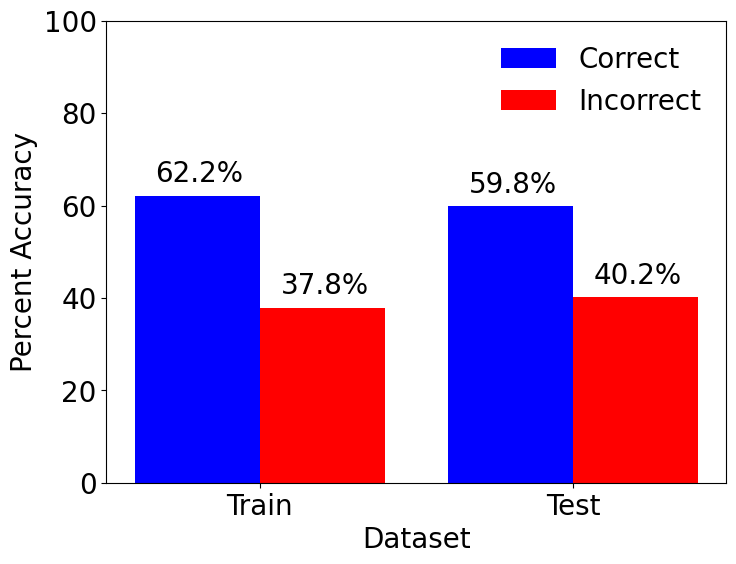

In [49]:
correct, incorrect = get_accuracy(model, X_train, y_train, X_test, y_test)
fig = plot_accuracy(correct, incorrect)
fig.savefig("m2_1_accuracy.png", bbox_inches="tight", transparent=True)

#### Feature importance

There is no great improvement compared to the out of the box logistic regression algorithm. Analyze feature importance for any biases. 

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

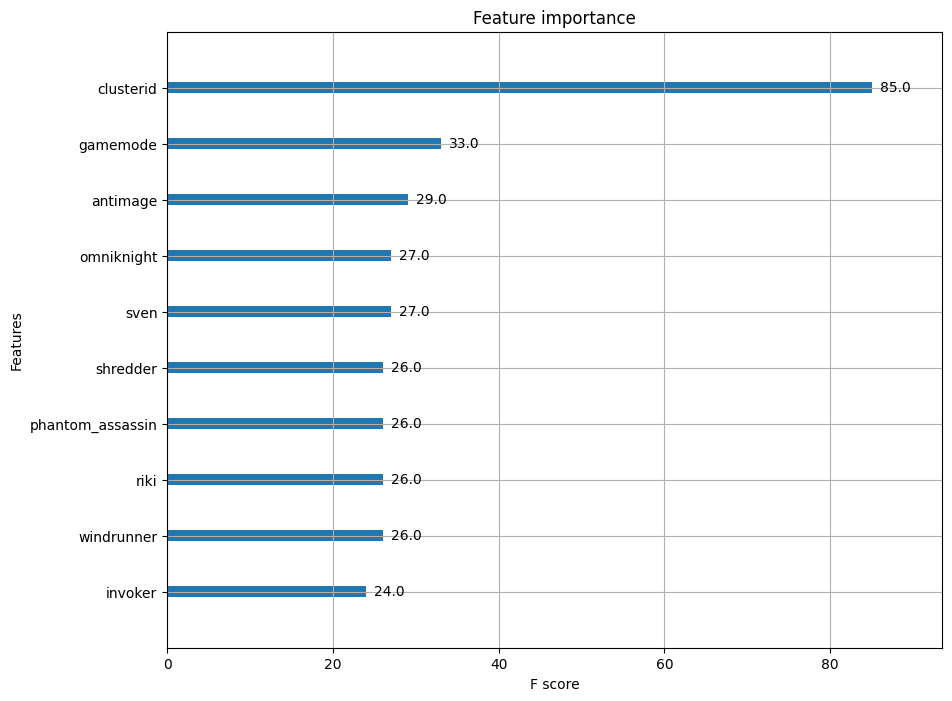

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax, max_num_features=10)

Instead of also training on region and game type features, only consider hero choices. 

In [51]:
X_train = data_train.drop(['teamwin', 'clusterid', 'gamemode', 'gametype'], axis=1, inplace=False)
X_test = data_test.drop(['teamwin', 'clusterid', 'gamemode', 'gametype'], axis=1, inplace=False)

Use same method as above for searching the hyperparameter space. For brevity, only the final hyperparameters are below. 

In [52]:
model = XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',      
    n_estimators=250,  
    learning_rate=0.2, 
    max_depth=3,    
    random_state=0, # repoducibiility
)
print(model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate_metrics(model, X_train, y_train, X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)
Training Accuracy: 0.6232703723691312
Testing Accuracy: 0.5973382552943463
Confusion Matrix:
 [[2368 2424]
 [1721 3781]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53  

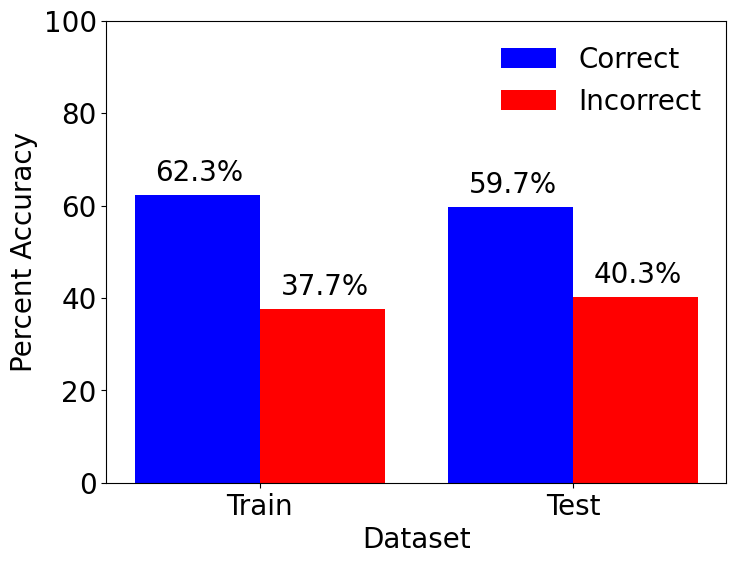

In [53]:
correct, incorrect = get_accuracy(model, X_train, y_train, X_test, y_test)
fig = plot_accuracy(correct, incorrect)
fig.savefig("m2_2_accuracy.png", bbox_inches="tight", transparent=True)